In [1]:
import kagglehub
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import random
import torchaudio.transforms as T
import torchaudio.functional as F

In [2]:
# -------------------------- DOWNLOAD DATA --------------------------
path = kagglehub.dataset_download("ejlok1/cremad")
AUDIO_DIR = os.path.join(path, "AudioWAV/")

Using Colab cache for faster access to the 'cremad' dataset.


In [3]:
#categorize files by emotion
#quantify how many of files per emotion
emotion_map = {
    'SAD': 'sadness',
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happiness',
    'NEU': 'neutral'
}

wav_paths = []
labels = []

print("Collecting files...")
for f in os.listdir(AUDIO_DIR):
    if not f.endswith(".wav"): continue
    parts = f.split("_")
    if len(parts) < 3: continue
    emo = emotion_map.get(parts[2])
    if emo:
        wav_paths.append(os.path.join(AUDIO_DIR, f))
        labels.append(emo)

data = {
    'audio_file': wav_paths,
    'emotion': labels
}
df = pd.DataFrame(data)
df

,audio_file,emotion
0,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav,disgust
1,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav,happiness
2,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav,happiness
3,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav,disgust
4,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav,disgust
...,...,...
7437,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav,anger
7438,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav,anger
7439,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav,anger
7440,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav,sadness


In [4]:
librosa.get_samplerate(df["audio_file"][0])

16000

In [5]:
#EDA

In [6]:
df.groupby("emotion").count()

,audio_file
emotion,
anger,1271
disgust,1271
fear,1271
happiness,1271
neutral,1087
sadness,1271


In [7]:
def add_length(file):
    return librosa.get_duration(path=file)

In [8]:
df["audio_length"] = df["audio_file"].transform(lambda x: add_length(x))

In [9]:
df["audio_length"].mean()

np.float64(2.5428836670249932)

In [10]:
df["audio_length"].max()

5.005

In [11]:
df.groupby("emotion")["audio_length"].mean()

,audio_length
emotion,
anger,2.584391
disgust,2.778297
fear,2.512276
happiness,2.342003
neutral,2.430809
sadness,2.593301


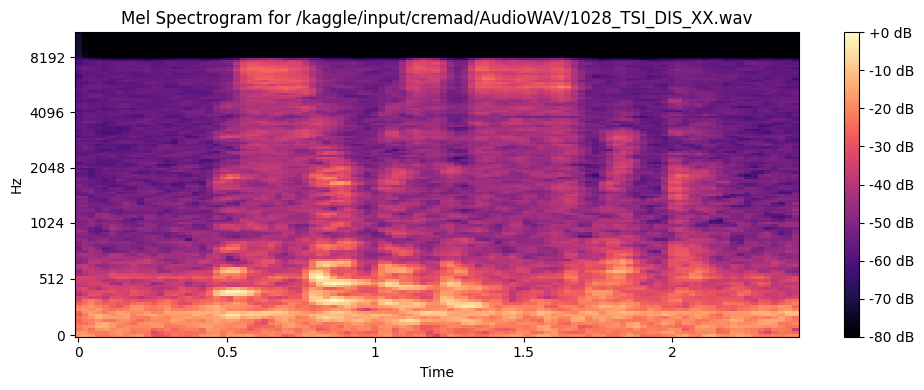

In [12]:
waveform, sample_rate = librosa.load(df["audio_file"][0])
mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db,
                         sr=sample_rate,
                         x_axis='time',
                         y_axis='mel',
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram for '+ df["audio_file"][0])
plt.tight_layout()
plt.show()

In [13]:
TARGET_DURATION = 3.0
SAMPLE_RATE = 16000
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_LEN = int(np.ceil(TARGET_DURATION * SAMPLE_RATE / HOP_LENGTH))
def extract_melspec(audio_path):
    #using 3 sec because avg audio len is 2.5 sec
    y, sr = librosa.load(audio_path, duration=TARGET_DURATION)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Pad spectrogram to fixed size
    if mel_spec_db.shape[1] < MAX_LEN:
        pad_width = MAX_LEN - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :MAX_LEN]
    return mel_spec_db

In [14]:
X = []
y = []
#Convert data in to mel spectograms
for idx, row in tqdm(df.iterrows(), total=len(df)):
    mel_spec = extract_melspec(row['audio_file'])
    X.append(mel_spec)
    y.append(row['emotion'])
X = np.array(X)
y = np.array(y)
X = X[:, np.newaxis, :, :]
print(X.shape, y.shape)

100%|██████████| 7442/7442 [02:01<00:00, 61.36it/s]


(7442, 1, 128, 94) (7442,)


In [15]:
# Output:
# anger = 0
# disgust = 1
# fear = 2
# happiness = 3
# neutral = 4
# sadness = 5
# surprise = 6
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [16]:
# -------------------------- SPEC AUGMENT --------------------------
class SpecAugment(nn.Module):
    def __init__(self, freq_mask=15, time_mask=50, p=0.5):
        super().__init__()
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = T.TimeMasking(time_mask_param=time_mask)
        self.p = p

    def forward(self, x):
        if random.random() < self.p:
            x = self.freq_mask(x)
        if random.random() < self.p:
            x = self.time_mask(x)
        return x

spec_augment = SpecAugment()

In [17]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_encoded,
                                                            test_size=0.2,
                                                            random_state=0,
                                                            stratify=y_encoded,
                                                            shuffle=True)
#normalize on train data
mean = np.mean(X_train_1)
std = np.std(X_train_1)
X_train_1 = (X_train_1 - mean) / std
X_test_1 = (X_test_1 - mean) / std

#convert to tensors
X_train1_tensor = torch.FloatTensor(X_train_1)
y_train1_tensor = torch.LongTensor(y_train_1)
X_test1_tensor = torch.FloatTensor(X_test_1)
y_test1_tensor = torch.LongTensor(y_test_1)

#convert to dataset and loader for faster processing
train_dataset = TensorDataset(X_train1_tensor, y_train1_tensor)
test_dataset = TensorDataset(X_test1_tensor, y_test1_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
def reset_weights(model):
    """Reset all model parameters to random initialization"""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [20]:
def run_model(model, train_loader, test_loader, num_epochs=100, augmentation=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    reset_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    # Early stopping variables
    best_test_acc = 0.0
    best_epoch = 0
    patience = 40
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
      # Training phase
      model.train()
      train_loss = 0.0
      train_correct = 0
      train_total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          if augmentation:
            inputs = spec_augment(inputs)
            if random.random() > 0.5:
              inputs = inputs + torch.randn_like(inputs) * 0.075


          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      # Validation phase
      model.eval()
      test_correct = 0
      test_total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs, 1)
              test_total += labels.size(0)
              test_correct += (predicted == labels).sum().item()

      # Calculate metrics
      avg_loss = train_loss / len(train_loader)
      train_acc = 100 * train_correct / train_total
      test_acc = 100 * test_correct / test_total

      history['train_loss'].append(avg_loss)
      history['train_acc'].append(train_acc)
      history['test_acc'].append(test_acc)


      # Early stopping check
      indicator = ""
      if test_acc > best_test_acc:
          best_test_acc = test_acc
          best_epoch = epoch + 1
          patience_counter = 0
          best_model_state = model.state_dict().copy()
          indicator = "*"
      else:
          patience_counter += 1

      if (epoch + 1) % 5 == 0:
          print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
                f'Loss: {avg_loss:.4f} | '
                f'Train Acc: {train_acc:.2f}% | '
                f'Test Acc: {test_acc:.2f}% {indicator}')

      if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Best test accuracy: {best_test_acc:.2f}% at epoch {best_epoch}")
            model.load_state_dict(best_model_state)
            break

    # Load best model if finished all epochs
    if patience_counter < patience and best_model_state is not None:
        print(f"Loading best model from epoch {best_epoch} ({best_test_acc:.2f}%)")
        model.load_state_dict(best_model_state)

    return history, model

In [21]:
def graph_model(history, model):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.numpy())

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=le.classes_))

  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.plot(history['train_loss'])
  ax1.set_title('Training Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid(True)

  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['test_acc'], label='Test Accuracy')
  ax2.set_title('Model Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()


#### MaxPooling with Increased Downstream Dropout

In [22]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(32),
    nn.Dropout(0.35),

    nn.Conv2d(32, 64, kernel_size=3,  padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(64),
    nn.Dropout(0.35),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(128),
    nn.Dropout(0.4),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(256),
    nn.Dropout(0.4),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),

    nn.Dropout(0.5),

    nn.Linear(256, 6))

In [23]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.35, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.35, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.4, inplace=False)
  (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Ma

In [24]:
%%time
#WITH AUGMENTATION
history, trained_model = run_model(model, train_loader, test_loader, num_epochs=100, augmentation=True)

cuda
Epoch [ 5/100] | Loss: 1.3529 | Train Acc: 46.56% | Test Acc: 35.46% *
Epoch [10/100] | Loss: 1.2794 | Train Acc: 50.48% | Test Acc: 46.47% *
Epoch [15/100] | Loss: 1.2305 | Train Acc: 52.12% | Test Acc: 52.52% *
Epoch [20/100] | Loss: 1.1845 | Train Acc: 54.48% | Test Acc: 50.57% 
Epoch [25/100] | Loss: 1.1531 | Train Acc: 54.96% | Test Acc: 51.78% 
Epoch [30/100] | Loss: 1.0952 | Train Acc: 58.37% | Test Acc: 51.71% 
Epoch [35/100] | Loss: 1.0967 | Train Acc: 58.24% | Test Acc: 56.01% 
Epoch [40/100] | Loss: 1.0784 | Train Acc: 58.76% | Test Acc: 55.88% 
Epoch [45/100] | Loss: 1.0458 | Train Acc: 60.47% | Test Acc: 53.93% 
Epoch [50/100] | Loss: 1.0426 | Train Acc: 60.62% | Test Acc: 60.17% *
Epoch [55/100] | Loss: 1.0287 | Train Acc: 60.84% | Test Acc: 56.21% 
Epoch [60/100] | Loss: 1.0307 | Train Acc: 60.91% | Test Acc: 56.62% 
Epoch [65/100] | Loss: 1.0214 | Train Acc: 61.30% | Test Acc: 57.22% 
Epoch [70/100] | Loss: 1.0182 | Train Acc: 61.73% | Test Acc: 58.43% 
Epoch [75/1


Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.76      0.75       254
     disgust       0.57      0.56      0.57       254
        fear       0.62      0.48      0.54       254
   happiness       0.72      0.54      0.62       254
     neutral       0.62      0.70      0.66       218
     sadness       0.54      0.74      0.62       255

    accuracy                           0.63      1489
   macro avg       0.64      0.63      0.63      1489
weighted avg       0.64      0.63      0.63      1489



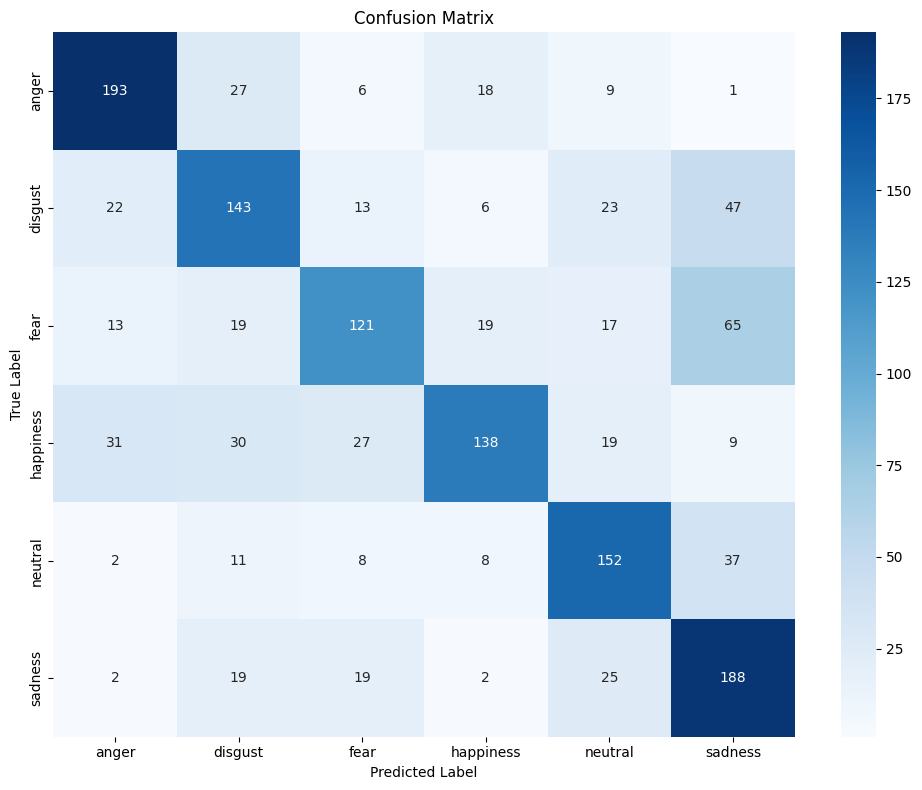

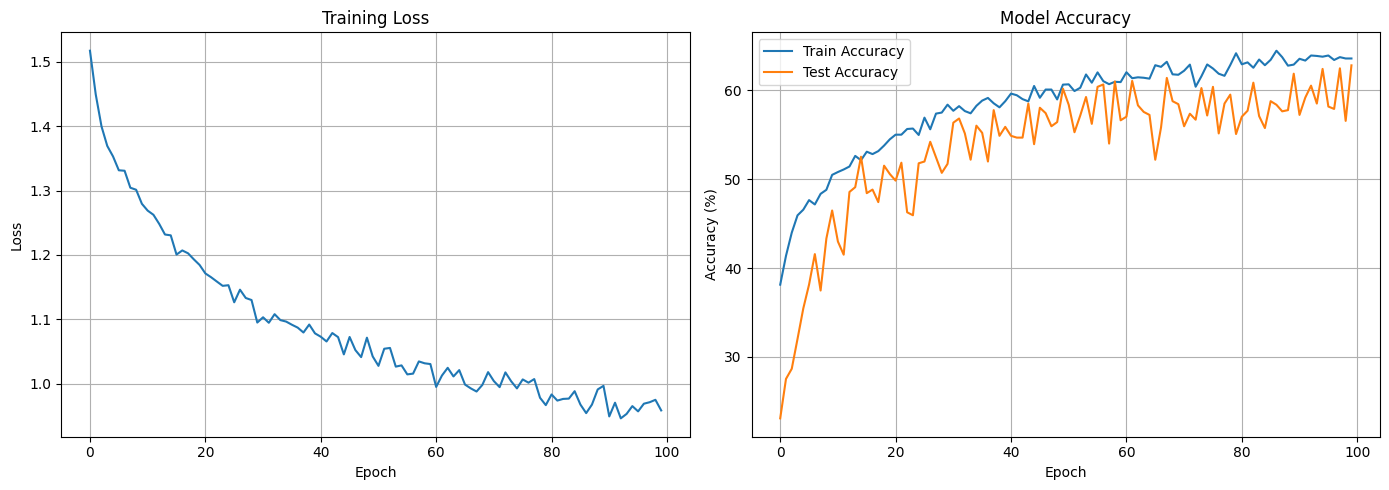

In [25]:
graph_model(history, trained_model)